In [1]:
import numpy as np
import subprocess

from base import *

print (prefixes)
print (inputFiles)
print (outputFiles)
print (commandFiles)
print (icFiles)
print (diffFiles)
print (diffOutputFiles)
print (matchingForwardFiles)
print (matchingAdjointFiles)
print (icAdjointFiles)
print (icGradientFiles)
print (innerProductFiles)
print (directories)

print (globalGradFiles)

['AcousticMonopole-0', 'AcousticMonopole-1', 'AcousticMonopole-2']
['magudi-0.inp', 'magudi-1.inp', 'magudi-2.inp']
['AcousticMonopole-0.forward_run.txt', 'AcousticMonopole-1.forward_run.txt', 'AcousticMonopole-2.forward_run.txt']
['AcousticMonopole-0.command.sh', 'AcousticMonopole-1.command.sh', 'AcousticMonopole-2.command.sh']
['AcousticMonopole-0.ic.q', 'AcousticMonopole-1.ic.q', 'AcousticMonopole-2.ic.q']
['AcousticMonopole-0.diff.q', 'AcousticMonopole-1.diff.q', '']
['AcousticMonopole-0.diff.txt', 'AcousticMonopole-1.diff.txt', '']
['AcousticMonopole-0-00000016.q', 'AcousticMonopole-1-00000020.q', '']
['AcousticMonopole-0-00000016.adjoint.q', 'AcousticMonopole-1-00000020.adjoint.q', '']
['', 'AcousticMonopole-1-00000016.adjoint.q', 'AcousticMonopole-2-00000020.adjoint.q']
['', 'AcousticMonopole-1.ic.adjoint.q', 'AcousticMonopole-2.ic.adjoint.q']
['AcousticMonopole.inner_product_controlRegion.txt', 'AcousticMonopole-1.inner_product.txt', 'AcousticMonopole-2.inner_product.txt']
['0'

In [2]:
baseline_ic = []
for k in range(Nsplit):
    baseline_ic += ['%s.ic.%1d.baseline.q'%(globalPrefix,k)]
print (baseline_ic)

for k in range(Nsplit):
    subprocess.check_call('cp '+baseline_ic[k]+' '+directories[k]+'/'+icFiles[k], shell=True)
    subprocess.check_call('cp '+globalPrefix+'.xyz'+' '+directories[k], shell=True)

for k in range(Nsplit):
    fID = open(commandFiles[k],'w')
    fID.write('cd '+directories[k]+'\n')
    fID.write('./forward --input '+inputFiles[k]+'\n')
    fID.write('cd ..'+'\n')
    if (k<Nsplit-1):
        kOffset = startTimestep + NtimestepOffset * (k+1)
        matchingFile = '%s/%s'%(directories[k],matchingForwardFiles[k])
        icFile = '%s/%s'%(directories[k+1],icFiles[k+1])
        diffFile = '%s'%(diffFiles[k])
        inputFile = '%s/%s'%(directories[k],inputFiles[k])
        fID.write('./qfile_zaxpy ' + diffFile + ' ' + \
                  "{:.16E}".format(-1.0) + ' ' + icFile + \
                  ' ' + matchingFile + ' --input ' + inputFile + '\n')
        
        diffOutputFile = '%s'%(diffOutputFiles[k])
        fID.write('./spatial_inner_product '+diffFile+' '+diffFile + \
                              ' --output ' + diffOutputFile + \
                              ' --input ' + inputFile + '\n')
    fID.close()
    subprocess.check_call('sh '+commandFiles[k], shell=True)

['AcousticMonopole.ic.0.baseline.q', 'AcousticMonopole.ic.1.baseline.q', 'AcousticMonopole.ic.2.baseline.q']


In [3]:
QoI0, subJ = QoI('.')
print (QoI0)
print (subJ)

5.8981888378643225e-08
[1.07935345e-08 1.18830621e-08 1.13426404e-08 1.29499030e-01
 1.20127484e-01]


In [4]:
from base import setOptionCommand

for k in range(Nsplit-1):
    fID = open(commandFiles[k],'w')
    fID.write(setOptionCommand(inputFiles[k]))
    fID.write('cd ' + directories[k] + '\n')
    fID.write('setOption "enable_adjoint_restart" "true"\n')
    fID.write('setOption "number_of_timesteps" '+str(Nts-NtimestepOffset)+'\n')
    fID.write('setOption "adjoint_restart\/accumulated_timesteps" '+str(int(0))+'\n')
    fID.write('setOption "adjoint_restart\/intermediate_end_timestep" '+str(NtimestepOffset)+'\n')
    fID.write('./adjoint --input ' + inputFiles[k] + '\n')
    fID.write('cd .. \n')
    
    matchingAdjointFile = '%s/%s'%(directories[k],matchingAdjointFiles[k])
    inputFile = '%s/%s'%(directories[k],inputFiles[k])
    diffFile = '%s'%(diffFiles[k])
    fID.write('./qfile_zaxpy ' + matchingAdjointFile + ' ' +       \
              "{:.16E}".format(matchingConditionWeight) + ' ' + diffFile +              \
              ' ' + matchingAdjointFile + ' --input ' + inputFile + '\n')
    
    fID.write('cd ' + directories[k] + '\n')
    fID.write('setOption "number_of_timesteps" '+str(NtimestepOffset)+'\n')
    fID.write('setOption "adjoint_restart\/accumulated_timesteps" '+str(Nts-NtimestepOffset)+'\n')
    fID.write('setOption "adjoint_restart\/intermediate_end_timestep" '+str(int(0))+'\n')
    fID.write('./adjoint --input ' + inputFiles[k] + '\n')
    
    fID.write('setOption "number_of_timesteps" '+str(Nts)+'\n')
    fID.write('setOption "enable_adjoint_restart" "false"\n')
    fID.write('cd .. \n')
    
    if (k>0):
        icAdjointFile = '%s/%s' % (directories[k],icAdjointFiles[k])
        diffFile = '%s.diff.q'%(prefixes[k-1])
        icGradFile = '%s' % (icGradientFiles[k])
        inputFile = '%s/%s'%(directories[k],inputFiles[k])
        fID.write('./qfile_zaxpy ' + icGradFile + ' ' +                                          \
                  "{:.16E}".format(-matchingConditionWeight) + ' ' + diffFile +                  \
                  ' ' + icAdjointFile + ' --input ' + inputFile + '\n')
    fID.close()

k = Nsplit - 1
fID = open(commandFiles[k],'w')
fID.write(setOptionCommand(inputFiles[k]))
fID.write('cd ' + directories[k] + '\n')
fID.write('setOption "enable_adjoint_restart" "false"\n')
fID.write('setOption "number_of_timesteps" '+str(Nts)+'\n')
fID.write('./adjoint --input ' + inputFiles[k] + '\n')
fID.write('cd .. \n')

icAdjointFile = '%s/%s' % (directories[k],icAdjointFiles[k])
diffFile = '%s.diff.q'%(prefixes[k-1])
icGradFile = '%s' % (icGradientFiles[k])
inputFile = '%s/%s'%(directories[k],inputFiles[k])
fID.write('./qfile_zaxpy ' + icGradFile + ' ' +                                          \
          "{:.16E}".format(-matchingConditionWeight) + ' ' + diffFile +                  \
          ' ' + icAdjointFile + ' --input ' + inputFile + '\n')
fID.close()

for k in range(Nsplit):
    subprocess.check_call('sh '+commandFiles[k], shell=True)

In [5]:
for k in range(NcontrolRegion):
    from os import path
    if (path.exists(globalGradFiles[k])):
        subprocess.check_call('rm '+globalGradFiles[k], shell=True)

fID = open(globalCommandFile,'w')
for k in range(Nsplit):
    kOffset = NtimestepOffset * k
    for j in range(NcontrolRegion):
        sliceGradFile = '%s/%s%s'%(directories[k],prefixes[k],gradientFiles[j])
        command = './paste_control_forcing ' + globalGradFiles[j] + ' ' + sliceGradFile + ' ' + \
                  str(int(totalTimestep)) + ' ' + str(int(kOffset)) + ' ' + str(int(Nts)) + '\n'
        fID.write(command)
fID.close()
    
subprocess.check_call('sh '+globalCommandFile, shell=True)

0

In [6]:
controlSpaceFiles = globalGradFiles + icGradientFiles[1:]

fID = open(globalCommandFile,'w')
fID.write(innerProductCommand(controlSpaceFiles,controlSpaceFiles))
fID.close()

subprocess.check_call('sh '+globalCommandFile, shell=True)

0

In [7]:
Grad, subGrad = readInnerProduct('gg.txt')
print (Grad)
print (subGrad)
print ('{:.16E}'.format(subGrad[0]))

3.592012302447478e-14
[1.28680324e-23 2.34591470e-14 1.24609760e-14]
1.2868032367438400E-23


In [8]:
Nk = 20
Ak = 10.0**(12.0-0.25*np.array(range(Nk)))
QoIk = np.zeros((Nk,),dtype=np.double)
Gradk = np.zeros((Nk,),dtype=np.double)
ek = np.zeros((Nk,),dtype=np.double)

In [9]:
baselineFiles = [''] + baseline_ic[1:]
stepFiles = globalControlForcingFiles + icFiles[1:]
for k, file in enumerate(stepFiles):
    stepFiles[k] = 'step/' + file
print (stepFiles)
print (globalControlForcingFiles)
print (icFiles)

['step/AcousticMonopole.control_forcing_controlRegion.dat', 'step/AcousticMonopole-1.ic.q', 'step/AcousticMonopole-2.ic.q']
['AcousticMonopole.control_forcing_controlRegion.dat']
['AcousticMonopole-0.ic.q', 'AcousticMonopole-1.ic.q', 'AcousticMonopole-2.ic.q']


In [10]:
baselineFiles = [''] + baseline_ic[1:]
stepFiles = globalControlForcingFiles + icFiles[1:]
for k, file in enumerate(stepFiles):
    stepFiles[k] = 'step/' + file
    
from os import path
if (path.exists(stepFiles[0])):
    subprocess.check_call('rm '+stepFiles[0], shell=True)

w2=initialConditionControllability
Grad = subGrad[0] + np.sum(subGrad[1:]) * w2
print ('Grad: ', Grad)
    
for k in range(Nk):
    command = zaxpyCommand(stepFiles,Ak[k],controlSpaceFiles,baselineFiles)
    subprocess.check_call(command, shell=True)
    command = distributeCommand('step')
    subprocess.check_call(command, shell=True)
    for j in range(Nsplit):
        commandFile = commandFiles[j]
        fID = open(commandFile,'w')
        fID.write(setOptionCommand(inputFiles[j]))
        fID.write('cd step/'+directories[j]+'\n')
        fID.write('setOption "controller_switch" "true"\n')
        fID.write('./forward --input ' + inputFiles[j] + ' --output ' + outputFiles[j] + '\n')
        fID.write('setOption "controller_switch" "false"\n')
        fID.write('cd ../../'+'\n')
        if (j<Nsplit-1):
            jOffset = startTimestep + NtimestepOffset * (j+1)
            matchingFile = 'step/%s/%s'%(directories[j],matchingForwardFiles[j])
            icFile = 'step/%s/%s'%(directories[j+1],icFiles[j+1])
            diffFile = 'step/%s'%(diffFiles[j])
            inputFile = 'step/%s/%s'%(directories[j],inputFiles[j])
            fID.write('./qfile_zaxpy ' + diffFile + ' ' + \
                      "{:.16E}".format(-1.0) + ' ' + icFile + \
                      ' ' + matchingFile + ' --input ' + inputFile + '\n')

            diffOutputFile = 'step/%s'%(diffOutputFiles[j])
            fID.write('./spatial_inner_product '+diffFile+' '+diffFile + \
                                  ' --output ' + diffOutputFile + \
                                  ' --input ' + inputFile + '\n')
        fID.close()
        subprocess.check_call('sh '+commandFile, shell=True)
    QoIk[k], subJ = QoI('step')
    Gradk[k] = (QoIk[k]-QoI0)/Ak[k]
    ek[k] = abs( (Gradk[k]-Grad)/Grad )
    print ("{:.16E}".format(Ak[k]), "{:.16E}".format(QoIk[k]), "{:.16E}".format(Gradk[k]), "{:.16E}".format(ek[k]))

Grad:  4.878815537904516e-23
1.0000000000000000E+12 5.9030689285464812E-08 4.8800906821586823E-23 2.6136348961333135E-04
5.6234132519034912E+11 5.9009328006952798E-08 4.8795326042035794E-23 1.4697548892606560E-04
3.1622776601683795E+11 5.8997317823170931E-08 4.8792187738773421E-23 8.2650383006587468E-05
1.7782794100389227E+11 5.8990564679095657E-08 4.8790422941706391E-23 4.6477728940889735E-05
1.0000000000000000E+11 5.8986767321695549E-08 4.8789430523240892E-23 2.6136347763664144E-05
5.6234132519034904E+10 5.8984631978561580E-08 4.8788872441952431E-23 1.4697479371822895E-05
3.1622776601683792E+10 5.8983431208332936E-08 4.8788558612185110E-23 8.2649802358728870E-06
1.7782794100389229E+10 5.8982755972397262E-08 4.8788382137216973E-23 4.6478119546361715E-06
1.0000000000000000E+10 5.8982376261472148E-08 4.8788282892329642E-23 2.6136115106851763E-06
5.6234132519034910E+09 5.8982162735005935E-08 4.8788227082084122E-23 1.4696812865058663E-06
3.1622776601683793E+09 5.8982042660464450E-08 4.878

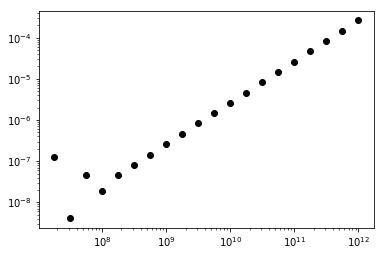

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
plt.loglog(Ak,ek,'ok')